## 1 Overview
This is an enviroment to trai and evaluate neural networks on learning logical calculi in a propositional logic. First the needed files are cloned from GitHub for it to run.

In [ ]:
# For Google Collab: Get repository and go to it in collab.
!git clone https://github.com/stereifberger/master-s-thesis
%cd master-s-thesis/

In [2]:
# For Google Colab if above does not move to right directory
%cd /content/master-s-thesis/

[Errno 2] No such file or directory: '/content/master-s-thesis/'
/home/str


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [8]:
os.getcwd()

'/home/str'

In [10]:
# For Jupyter Notebook (also in VSCode) after starting Jupyter server: Go to right directory.
%cd master-s-thesis/

/home/str/master-s-thesis


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# Install required dependencies - not necessary on Google Colab
!pip install -r requirements.txt

In [11]:
# Import required libraries from imports.py
from imports import *

## 2 Create dataset
First the dataset for traiing is generated. For this the function "create_dataset" from "generation.py" utilizes the functions "gen_outp_PA" to generate a set of random starting formulas, for which iterativly the applicability of rules is checked. All applicable rules are then used to generate new derivations. In each iteration of gen_oupt_PA, set by the iterations variable, new, longer examples are generated.

**Rules.** The rules are defined in calculi.py. Two sets are avaiable: Intuitionistic propositional logic (set below via "calculus = ip") and classical propositional logic (set below via "calculus = cl").

**Dataset entries.**
- **x_trai.** traiing input: [INDEX, PREMISES, DERIVATION SYMBOL, CONCLUSION]
- **y_trai_ordered.** Dataset of correct derivations where each sublist i correspnds to INDEX: [DERIVATIONS_0...DERIVATION_N]

**Encoding.** Propositional variables and logical constants are encoded as integers. The integers are then one-hot-encoded into unique sequences containing only 0s and ones with the length of the maximum integer value, the feature length. The shape of the individual entries is 2D: [SEQUENCE LENGTH, FEATURE LENGTH].

**Example entries withouth numerical representation and one-hot-encoding.**
- **x_trai.** [2345, A, A THEN B, DERIVES, B OR C]
- **y_trai_ordered.** Sublist 2345 is entry entry: [[A, A THEN B, B, B OR C], [A, A THEN B, B, A AND B, B OR C]]


In [12]:
# Define input (as two and three dimensional vector) and output datset as outputs of generation.create_datset
# It applies rules of classical logic up to two times to do so on randomly generated premises
x_trai_2d, x_trai_3d, y_trai_ordered, max_y_trai_len = generation.create_dataset(iterations = [1,2], calculus = calculi.cl)

Processed at iteration 1:   0%|          | 0/2 [00:00<?, ?it/s]

Processed at iteration 2:   0%|          | 0/10 [00:00<?, ?it/s]

Processed premises for sample conclusions at iteration 2:   0%|          | 0/12 [00:00<?, ?it/s]

Checked derivations for sample conclusions:   0%|          | 0/135 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Processed entries for x_train and y_tdict:   0%|          | 0/46 [00:00<?, ?it/s]

Padded y_train_ordered:   0%|          | 0/19 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/19 [00:00<?, ?it/s]

LENINPT: 19
LENy_t: 19
Number x_train examples: 19
Average number ground truth examples/x_train example: 2.4210526315789473


In [13]:
torch.save(x_trai_2d, 'x_trai_2d.pt')                 # Save two dimensional input dataset to backup file
torch.save(x_trai_3d, 'x_trai_3d.pt')                 # Save three dimensional input dataset to backup file
torch.save(y_trai_ordered, 'y_trai_ordered.pt')       # Save output dataset to backup file
with open('Medium_max_y_trai_len.json', 'w') as file: # Save number with maximum length of derivations in output dataset to backup file
    json.dump(max_y_trai_len, file)

## 3 Prepare dataset and define models for traiing
Next with pytorch's dataloader the single traiing entries in x_trai are assigned to batches of size "batch size" in mixed order. Then the different models are defined using definitions from "architectures.py". These models are:

- Feedforward network (net)
- Recurrent neural network (RNNNet)
- Long-short-term memory (LSTMNet)
- Transformers (TransformerModel)

In [14]:
if torch.cuda.is_available():                                           # Empty avaiable GPU memory when GPU is present
    torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # GPU is defined as 'device' when present for using it

In [15]:
two_d_shape = x_trai_2d.shape               # Get the 2d traiing dataset's shape for the model definitions later
thr_d_shape = x_trai_3d.shape               # Get the 23 traiing dataset's shape for the model definitions later
max_y_length = int(max_y_trai_len/14)       # Define maximum length of derivations for non one-hot encoded dataset

In [16]:
x = torch.argmax(x_trai_3d, dim=2)          # Reverse one-hot encoding for encoder-decoder models
x[:, 0] = x_trai_2d[:, 0]
x_trai_nu = x

In [17]:
trai_si = int(0.8 * len(x_trai_2d))                                     # Set trai-test split to 80-20 [^1]
test_si = len(x_trai_2d) - trai_si
x_trai_2d, x_test_2d = random_split(x_trai_2d, [trai_si, test_si])      # Choose random derivations from datsets distributed by trai-test split
x_trai_3d, x_test_3d = random_split(x_trai_3d, [trai_si, test_si])
x_trai_nu, x_test_nu = random_split(x_trai_nu, [trai_si, test_si])

In [18]:
trai_dl_2d = DataLoader(dataset = x_trai_2d, shuffle = True, batch_size = 16)   # Create batches of size 16 from datasets
test_dl_2d = DataLoader(dataset = x_test_2d, shuffle = True, batch_size = 16)
trai_dl_3d = DataLoader(dataset = x_trai_3d, shuffle = True, batch_size = 16)
test_dl_3d = DataLoader(dataset = x_test_3d, shuffle = True, batch_size = 16)
trai_dl_nu = DataLoader(dataset = x_trai_nu, shuffle = True, batch_size = 64)
test_dl_nu = DataLoader(dataset = x_test_nu, shuffle = True, batch_size = 64)

In [19]:
y_trai = y_trai_ordered.to(device)                      # Load ground truth data to GPU
y_trai_3d = y_trai.view(int(len(y_trai)),               # Reshape training 3d data
                        int(len(y_trai[0])),
                        int(len(y_trai[0][0])/14), 14)

For experiments the below parameters of the architectures have to be specified in accordance to which one is test.

In [20]:
# Define the Encoder-Decoder networks
## FFN | Inputs: input_dim, hidden dim
encoder_ffn = architectures.Encoder_FFN(thr_d_shape[1], 150)
decoder_ffn = architectures.Decoder_FFN((max_y_length*14), 150)
ffn_ed_model = architectures.Seq2Seq(encoder_ffn, decoder_ffn, device)
## RNN | Inputs: input_dim, embedding dim, hidden dim, nr layers
encoder_rnn = architectures.Encoder_RNN(thr_d_shape[1], 150, 150, 1)
decoder_rnn = architectures.Decoder_RNN(14, 150, 150, 3)
rnn_ed_model = architectures.Seq2Seq(encoder_rnn, decoder_rnn, device)
## LSTM | Inputs: input_dim, embedding dim, hidden dim, nr layers, droput
encoder_lstm = architectures.Encoder_LSTM(thr_d_shape[1], 150, 150, 1, 0)
decoder_lstm = architectures.Decoder_LSTM(14, 150, 150, 3, 0)
lst_ed_model = architectures.Seq2Seq(encoder_lstm, decoder_lstm, device)
## Transformer-Encoder | Inputs:  input_dim, emb_dim, num_heads, hidden_dim, num_layers, dropout
encoder_tra = architectures.TransformerEncoder(thr_d_shape[1], 150, 5, 150, 1, dropout=0)
# Transformer-Decoder | Inputs: output_dim, emb_dim, num_heads, hidden_dim, num_layers
decoder_tra = architectures.TransformerDecoder(14, 150, 5, 150, 3)
tra_ed_model = architectures.Seq2SeqTransformer(encoder_tra, decoder_tra, device)

/home/str/environments/general/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
lr = 0.001                                                              # Define Learning rate
ffn_ed_optimizer = torch.optim.AdamW(ffn_ed_model.parameters(),lr=lr)   # Define optimizers based on AdamW for models
rnn_ed_optimizer = torch.optim.AdamW(rnn_ed_model.parameters(),lr=lr)
lst_ed_optimizer = torch.optim.AdamW(lst_ed_model.parameters(),lr=lr)
tra_ed_optimizer = torch.optim.AdamW(tra_ed_model.parameters(),lr=lr)

# 4 Training

In [25]:
criterion = nn.CrossEntropyLoss()

## 4.1 FFN Encoder-Decoder

In [22]:
ffn_ed_model.to(device)                                                 # Load model to GPU

Seq2Seq(
  (encoder): Encoder_FFN(
    (embedding): Embedding(47, 150)
    (fc_hidden): Linear(in_features=150, out_features=150, bias=True)
  )
  (decoder): Decoder_FFN(
    (fc_hidden): Linear(in_features=150, out_features=150, bias=True)
    (fc_out): Linear(in_features=150, out_features=840, bias=True)
  )
)

In [ ]:
#x_trai_nu_2 = [x_trai_nu[i][1:].tolist() for i in range(len(x_trai_nu))]

In [26]:
# Tain model and save results
FFN_CELtrai, FFN_CELtest, FFN_ACCtrai, FFN_ACCtest = schedule.train_model(model = ffn_ed_model,
                                                                         dataloader_train = trai_dl_nu,
                                                                         dataloader_test = test_dl_nu,
                                                                         optimizer = ffn_ed_optimizer,
                                                                         criterion = criterion,
                                                                         epochs = 50,
                                                                         device = device,
                                                                         max_y_length = max_y_length,
                                                                         y_train = y_trai)
torch.save(ffn_ed_model.state_dict(), 'addition_model.pth')

Ep. 01, CEL-Train: 404.8895| CEL-Test: 401.2387 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 02, CEL-Train: 400.7424| CEL-Test: 397.0207 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 03, CEL-Train: 396.4962| CEL-Test: 391.9279 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 04, CEL-Train: 391.3502| CEL-Test: 385.3990 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 05, CEL-Train: 384.7742| CEL-Test: 377.0980 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 06, CEL-Train: 376.4859| CEL-Test: 366.9352 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 07, CEL-Train: 366.3484| CEL-Test: 355.1940 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 08, CEL-Train: 354.5573| CEL-Test: 342.8496 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 09, CEL-Train: 341.8942| CEL-Test: 331.7638 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 10, CEL-Train: 329.8445| CEL-Test: 323.9854 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 11, CEL-Train: 319.9699| CEL-Test: 320.0648 | ACC-Train: 0.0000 | ACC-Test:  0.0000
Ep. 12, CEL-Train: 312.7289| CEL

In [27]:
schedule.sanity(ffn_ed_model, test_dl_nu, device, max_y_length) # A sanity test for wheter the outputs look appropriate

INPUT: (q(r∨q))⊢(p∨(r∨q))
OUTPUT: q(r∨q)(q∨q)(q)q
INPUT: ((p→p)(q∨(s→r)))⊢((p→p)∨q)
OUTPUT: (p→p)(q∨(s→r))(q∨(p)p))(
INPUT: ((p→p)(q∨(s→r)))⊢((p→p)∨p)
OUTPUT: (p→p)(q∨(s→r))(q∨(p)p))(
INPUT: (q(r∨q))⊢(q→(r∨q))
OUTPUT: q(r∨q)(q∨q)(q)q


In [28]:
del ffn_ed_model            # Delete model from GPU to make space for new models
torch.cuda.empty_cache()    # Empty newly avaiable GPU memory

## 4.3 LSTM Encoder-Decoder

In [32]:
lst_ed_model.to(device)     # Load model to GPU

Seq2Seq(
  (encoder): Encoder_LSTM(
    (embedding): Embedding(47, 150)
    (rnn): LSTM(150, 150, batch_first=True)
  )
  (decoder): Decoder_LSTM(
    (rnn): LSTM(150, 150, num_layers=3, batch_first=True)
    (fc_out): Linear(in_features=150, out_features=14, bias=True)
  )
)

In [34]:
# Tain model and save results
LSTM_CELtrai, LSTM_CELtest, LSTM_ACCtrai, LSTM_ACCtest = schedule.train_model(model = lst_ed_model,
                                                                             dataloader_train = trai_dl_nu,
                                                                             dataloader_test = test_dl_nu,
                                                                             optimizer = lst_ed_optimizer,
                                                                             criterion = criterion,
                                                                             epochs = 50,
                                                                             device = device,
                                                                             max_y_length = max_y_length,
                                                                             y_train = y_trai_3d)
torch.save(lst_ed_model.state_dict(), 'addition_model.pth')     # Save model

Ep. 01, CEL-Train: 2.6250| CEL-Test: 2.5853 | ACC-Train: 0.0667 | ACC-Test:  0.0542
Ep. 02, CEL-Train: 2.5863| CEL-Test: 2.5321 | ACC-Train: 0.0578 | ACC-Test:  0.5625
Ep. 03, CEL-Train: 2.5350| CEL-Test: 2.4445 | ACC-Train: 0.5444 | ACC-Test:  0.5625
Ep. 04, CEL-Train: 2.4507| CEL-Test: 2.2881 | ACC-Train: 0.5400 | ACC-Test:  0.5625
Ep. 05, CEL-Train: 2.3000| CEL-Test: 2.0416 | ACC-Train: 0.5400 | ACC-Test:  0.5625
Ep. 06, CEL-Train: 2.0614| CEL-Test: 1.7885 | ACC-Train: 0.5400 | ACC-Test:  0.5542
Ep. 07, CEL-Train: 1.8132| CEL-Test: 1.6723 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 08, CEL-Train: 1.6925| CEL-Test: 1.6893 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 09, CEL-Train: 1.6993| CEL-Test: 1.7201 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 10, CEL-Train: 1.7252| CEL-Test: 1.7165 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 11, CEL-Train: 1.7236| CEL-Test: 1.6886 | ACC-Train: 0.5444 | ACC-Test:  0.5542
Ep. 12, CEL-Train: 1.7016| CEL-Test: 1.6531 | ACC-Train: 0.5456 | ACC-Test: 

In [ ]:
schedule.sanity(lst_ed_model, test_dl_nu, device, max_y_length) # A sanity test for wheter the outputs look appropriate

In [ ]:
del lst_ed_model            # Delete model from GPU to make space for new models
torch.cuda.empty_cache()    # Empt newly avaiable GPU memory

## 4.4 Transformer

In [35]:
tra_ed_model.to(device)     # Load model to GPU

Seq2SeqTransformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(47, 150)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
          )
          (linear1): Linear(in_features=150, out_features=150, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=150, out_features=150, bias=True)
          (norm1): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
      )
    )
  )
  (decoder): TransformerDecoder(
    (embedding): Embedding(14, 150)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Transfo

In [38]:
TRA_CELtrai, TRA_CELtest, TRA_ACCtrai, TRA_ACCtest = schedule.train_model(model = tra_ed_model,
                                                                         dataloader_train = trai_dl_nu,
                                                                         dataloader_test = test_dl_nu,
                                                                         optimizer = tra_ed_optimizer,
                                                                         criterion = criterion,
                                                                         epochs = 50,
                                                                         device = device,
                                                                         max_y_length = max_y_length,
                                                                         y_train = y_trai_3d)
torch.save(tra_ed_model.state_dict(), 'addition_model.pth')

Ep. 01, CEL-Train: 2.7253| CEL-Test: 1.7911 | ACC-Train: 0.1022 | ACC-Test:  0.5542
Ep. 02, CEL-Train: 1.8104| CEL-Test: 1.6912 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 03, CEL-Train: 1.7019| CEL-Test: 1.6253 | ACC-Train: 0.5322 | ACC-Test:  0.5542
Ep. 04, CEL-Train: 1.6503| CEL-Test: 1.5892 | ACC-Train: 0.5489 | ACC-Test:  0.5542
Ep. 05, CEL-Train: 1.6010| CEL-Test: 1.5816 | ACC-Train: 0.5500 | ACC-Test:  0.5542
Ep. 06, CEL-Train: 1.5566| CEL-Test: 1.6208 | ACC-Train: 0.5433 | ACC-Test:  0.5542
Ep. 07, CEL-Train: 1.5511| CEL-Test: 1.6320 | ACC-Train: 0.5489 | ACC-Test:  0.5542
Ep. 08, CEL-Train: 1.5445| CEL-Test: 1.5890 | ACC-Train: 0.5544 | ACC-Test:  0.5542
Ep. 09, CEL-Train: 1.5227| CEL-Test: 1.5562 | ACC-Train: 0.5533 | ACC-Test:  0.5542
Ep. 10, CEL-Train: 1.5282| CEL-Test: 1.5596 | ACC-Train: 0.5511 | ACC-Test:  0.5542
Ep. 11, CEL-Train: 1.5186| CEL-Test: 1.5963 | ACC-Train: 0.5589 | ACC-Test:  0.5542
Ep. 12, CEL-Train: 1.5047| CEL-Test: 1.6271 | ACC-Train: 0.5578 | ACC-Test: 

In [39]:
schedule.sanity(tra_ed_model, test_dl_nu, device, max_y_length) # A sanity test for wheter the outputs look appropriate

INPUT: (q(r∨q))⊢(q→(r∨q))
OUTPUT: 
INPUT: ((p→p)(q∨(s→r)))⊢((p→p)∨q)
OUTPUT: 
INPUT: ((p→p)(q∨(s→r)))⊢((p→p)∨p)
OUTPUT: 
INPUT: (q(r∨q))⊢(p∨(r∨q))
OUTPUT: 


In [40]:
del tra_ed_model            # Delete model from GPU to make space for new models
torch.cuda.empty_cache()    # Empt newly avaiable GPU memory

## 5 Plot results
Here results from the preset parameters above can be plotted. Results in the thesis are plotted from csv files using tikz.

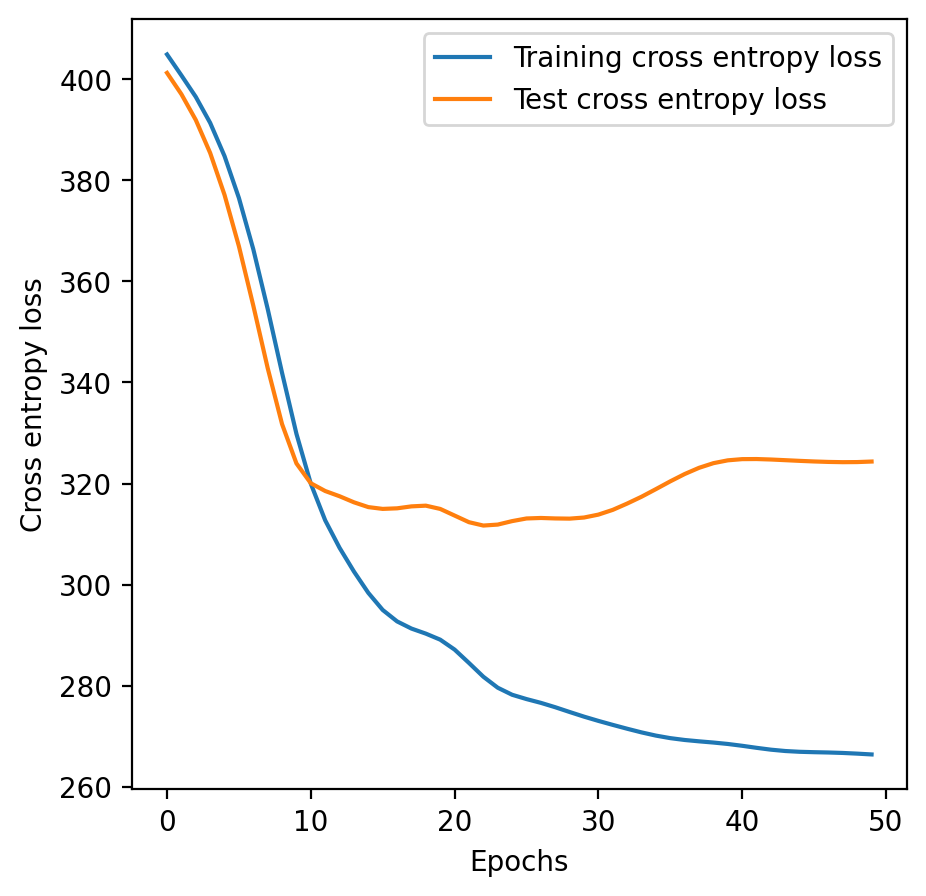

In [56]:
# Feedforward Network,  Medium Dataset, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/freefont/FreeSerif.otf')
plt.plot(x_data, FFN_CELtrai, label='Training cross entropy loss')
plt.plot(x_data, FFN_CELtest, label='Test cross entropy loss')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.show()

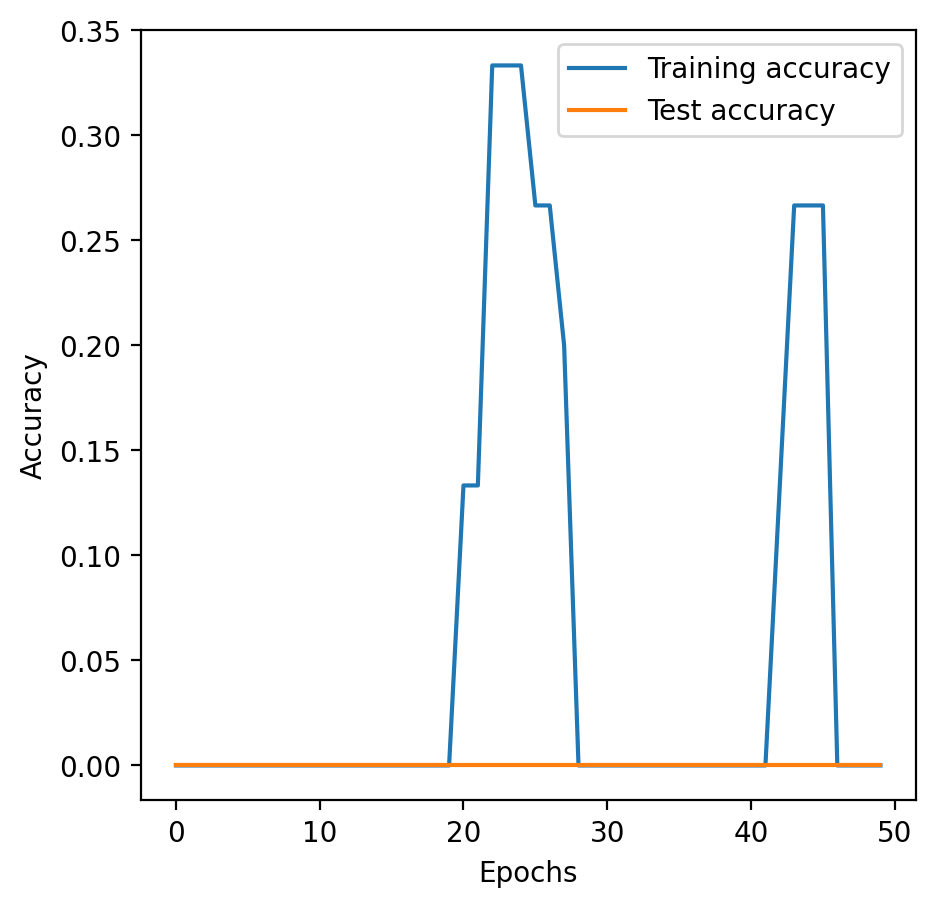

In [57]:
# Feedforward Network, Medium Dataset, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
plt.plot(x_data, FFN_ACCtrai, label='Training accuracy')
plt.plot(x_data, FFN_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

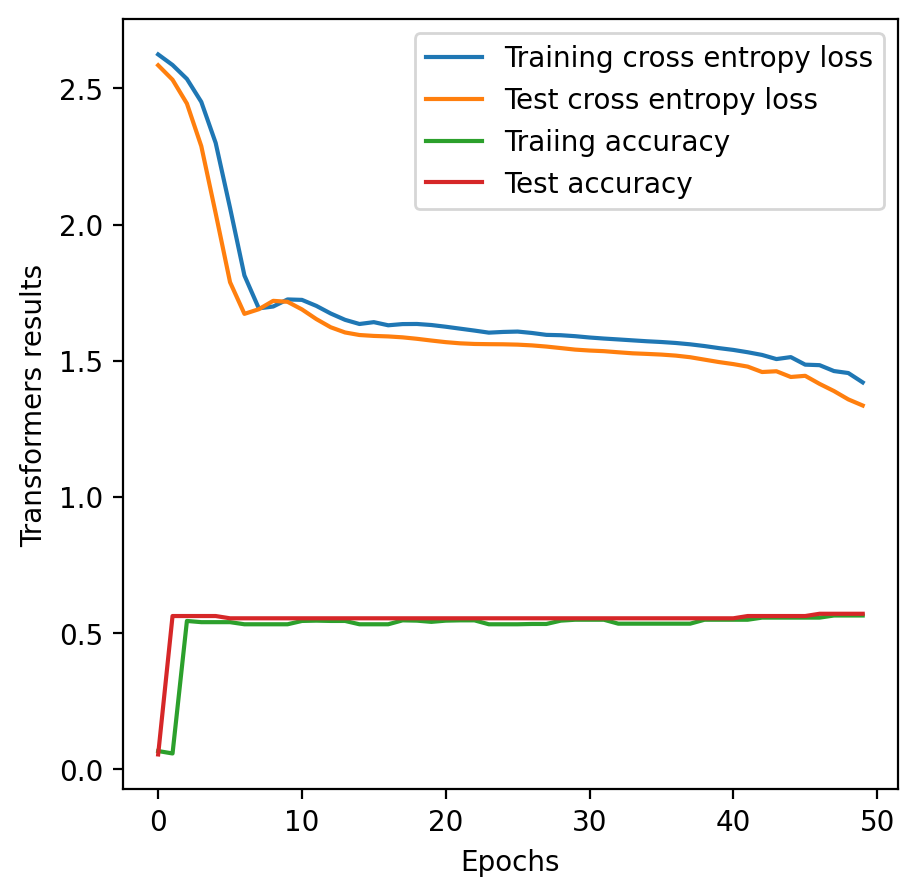

In [58]:
# Long Short-Term Memory, Medium, Accuracy, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
plt.plot(x_data, LSTM_CELtrai, label='Training cross entropy loss')
plt.plot(x_data, LSTM_CELtest, label='Test cross entropy loss')
plt.plot(x_data, LSTM_ACCtrai, label='Traiing accuracy')
plt.plot(x_data, LSTM_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

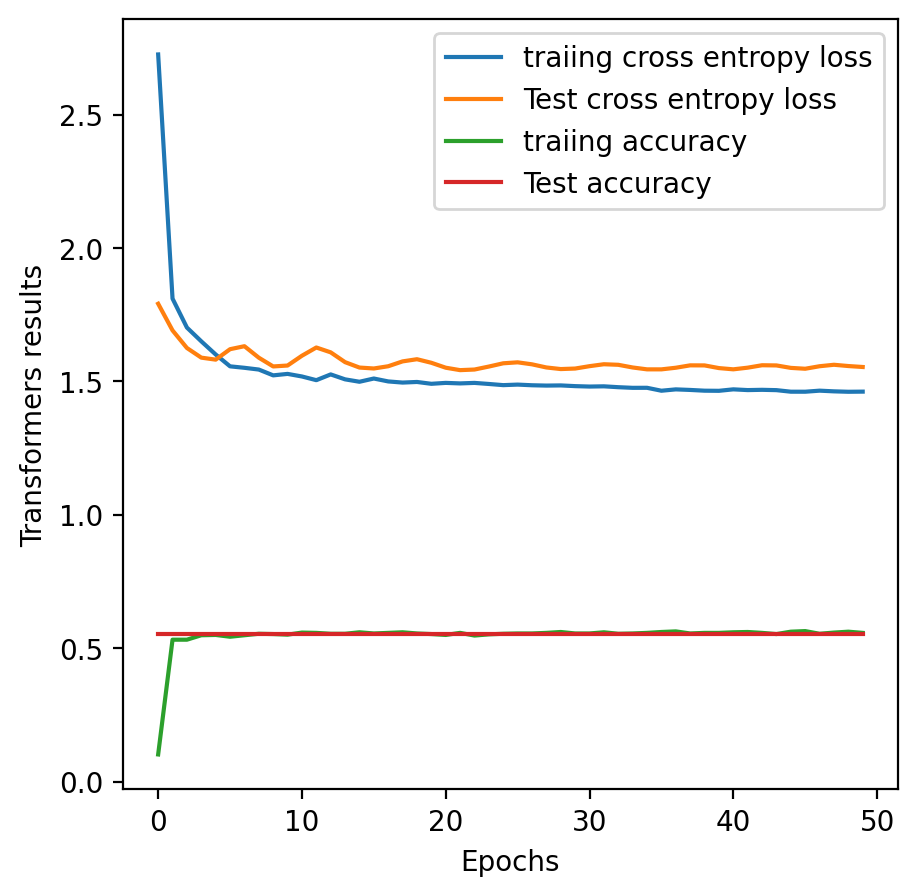

In [51]:
# Transformer, Medium, Accuracy, Cross Entropy Loss
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
plt.plot(x_data, TRA_CELtrai, label='Training cross entropy loss')
plt.plot(x_data, TRA_CELtest, label='Test cross entropy loss')
plt.plot(x_data, TRA_ACCtrai, label='Training accuracy')
plt.plot(x_data, TRA_ACCtest, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

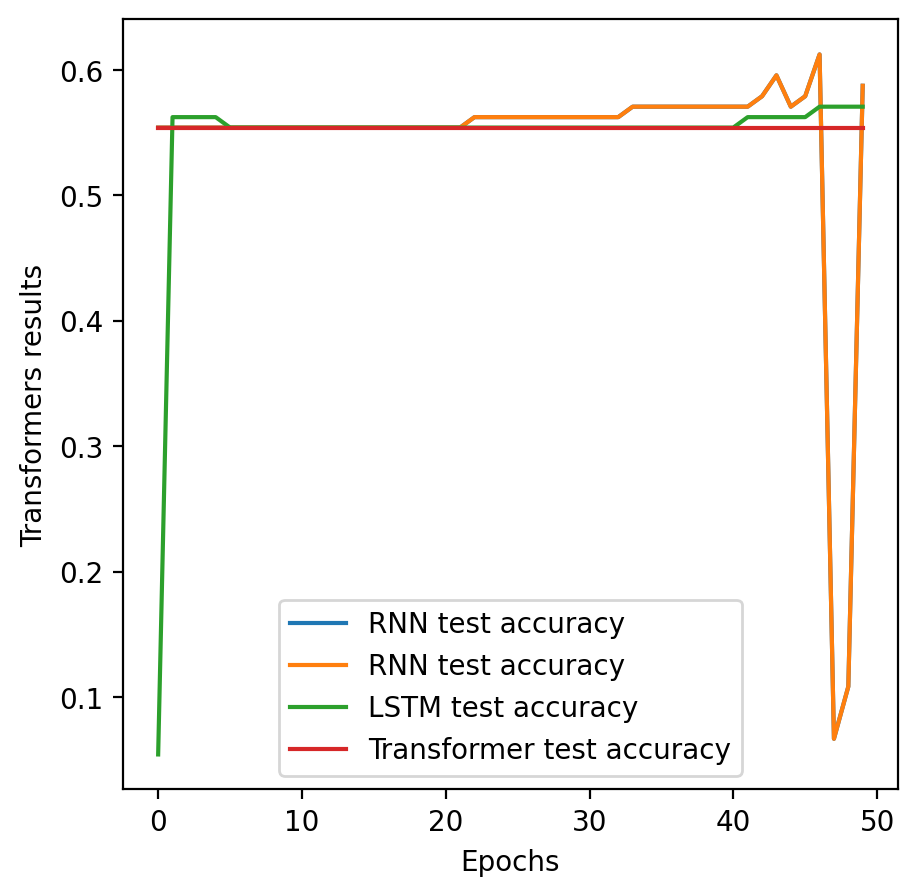

In [53]:
# Test-Accuracy all Networks, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
#plt.plot(x_data, FFN_ACCtest, label='FFN Test accuracy')
plt.plot(x_data, RNN_ACCtest, label='RNN test accuracy')
plt.plot(x_data, RNN_ACCtest, label='RNN test accuracy')
plt.plot(x_data, LSTM_ACCtest, label='LSTM test accuracy')
plt.plot(x_data, TRA_ACCtest, label='Transformer test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()

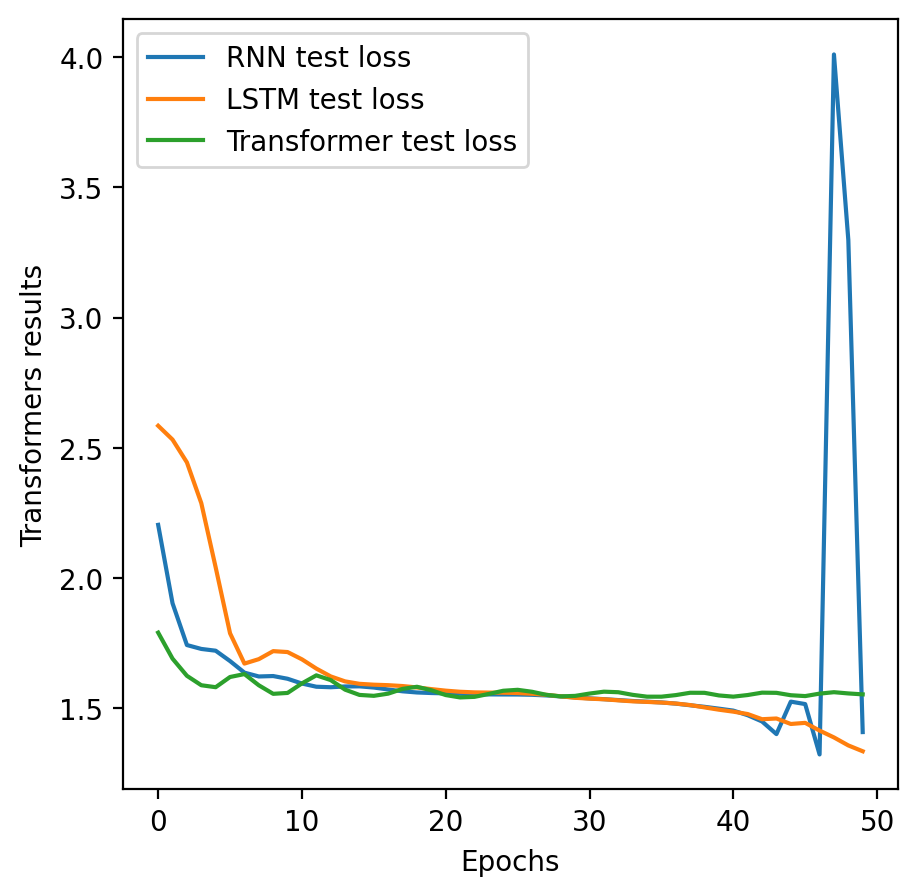

In [54]:
# Test-Accuracy all Networks, Accuracy
plt.figure(figsize=(5, 5), dpi=200)
x_data = list(range(50))
#plt.plot(x_data, FFN_ACCtest, label='FFN Test accuracy')
plt.plot(x_data, RNN_CELtest, label='RNN test loss')
plt.plot(x_data, LSTM_CELtest, label='LSTM test loss')
plt.plot(x_data, TRA_CELtest, label='Transformer test loss')
plt.xlabel('Epochs')
plt.ylabel('Transformers results')
plt.legend()
plt.show()